In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "text.latex.preamble": r"\usepackage{fourier}"
})

#### Simulation parameters

For the anharmónic case, put $\lambda\neq 0$.

In [12]:
N = 1000             # Number of trajectory points, (x_0, x_1, ..., x_N), recommended from 10^2 to 10^3
epsilon = 0.314      # Step of imaginary time (tau), recommended epsilon*omega/(2*pi) from 1/10 to 1/20
                     # T = N * epsilon (total time)

a = 1.1 * np.sqrt(epsilon)    # Metropolis step proportional to 2*sqrt(epsilon)
N_E = 500                     # Number of trajectories to promediate (at least 10^2)

antiperiodic = False

N_bar = 5            # Number of intermediate trajectories before selecting a definitive one
n_bar = 10           # Number of metropolis steps before deciding initial position

# V(x) = (m/2)omega^2 * x^2 + lambda * x^4
hbar = 1
m = 1
omega = 1
Lambda = 0

##### Potential centered at $x=0$

$$ V(x) = \frac{m}{2} \omega^2 x^2 + \lambda x^4 $$

In [3]:
def V(x):
    return (m/2) * omega**2 * x**2 + Lambda * x**4 

def V_prime(x):
    return m * omega**2 * x + 4 * Lambda * x**3

##### Two well potential at $x=\pm f$

$$ V(x) = \lambda (x^2 - f^2)^2

In [41]:
f = np.sqrt(2)     # Two well potential minima location

def V(x):
    return Lambda * (x**2 - f**2) ** 2

def V_prime(x):
    return 4 * Lambda * x * (x**2 - f**2)

We are going to estimate $E_0$ with the following operator, defined as a functional of the trajectory:

$$ f[x(\tau)] = V[x(\tau)] + \frac{1}{2}x(\tau)V'[x(\tau)] $$

In [4]:
def f_local(x):
    return V(x) + (1/2) * x * V_prime(x)

#### Metropolis algorithm

We approximate the euclidean action as:

$$ S_\mathrm{E}[x(\tau)] = \int_0^T d\tau\,H[x(\tau)] \approx \epsilon\sum_{i=0}^{N-1} \left[\frac{m}{2}\left(\frac{x_{i+1} - x_i}{\epsilon}\right)^2 + V\left(\frac{x_{i+1} + x_i}{2}\right)\right]. $$

So the difference between the new action value and the old one is:

$$\Delta S_\mathrm{E} = \epsilon \left[\frac{m}{2}\left(\frac{x'_i - x_{i-1}}{\epsilon}\right)^2 + V\left(\frac{x'_i + x_{i-1}}{2}\right) + \frac{m}{2}\left(\frac{x_{i+1} - x'_i}{\epsilon}\right)^2 + V\left(\frac{x_{i+1} + x'_i}{2}\right)\right] - \epsilon \left[\frac{m}{2}\left(\frac{x_i - x_{i-1}}{\epsilon}\right)^2 + V\left(\frac{x_i + x_{i-1}}{2}\right) + \frac{m}{2}\left(\frac{x_{i+1} - x_i}{\epsilon}\right)^2 + V\left(\frac{x_{i+1} + x_i}{2}\right)\right]
$$

In [5]:
def delta_S(x, i, new_pos):
    """
    Computes the change in the Euclidean Action when altering the trajectory x[i] -> new_pos.

    It assumes periodic boundary condition x_0 = x_N.
    """
    # Computing old and new index, with boundary condition in mind (mod N)
    im1 = (i - 1) % N
    ip1 = (i + 1) % N

    # Deltas viejos
    dx1_old = x[i] - x[im1]
    dx2_old = x[ip1] - x[i]
    midpoint1_old = (x[i] + x[im1]) / 2
    midpoint2_old = (x[ip1] + x[i]) / 2

    # Deltas nuevos
    dx1_new = new_pos - x[im1]
    dx2_new = x[ip1] - new_pos
    midpoint1_new = (new_pos + x[im1]) / 2
    midpoint2_new = (x[ip1] + new_pos) / 2

    # We only need to compute the discretized term of the action related to position i
    old_term = epsilon * (
        (m / 2) * (dx1_old / epsilon)**2 + V(midpoint1_old) +
        (m / 2) * (dx2_old / epsilon)**2 + V(midpoint2_old)
    )
    new_term = epsilon * (
        (m / 2) * (dx1_new / epsilon)**2 + V(midpoint1_new) +
        (m / 2) * (dx2_new / epsilon)**2 + V(midpoint2_new)
    )

    return new_term - old_term

In the article by Creutz and Freedman, however, it is taken instead:

$$ S_\mathrm{E}[x(\tau)] = \int_0^T d\tau\,H[x(\tau)] \approx \epsilon\sum_{i=0}^{N-1} \left[\frac{m}{2}\left(\frac{x_{i+1} - x_i}{\epsilon}\right)^2 + V(x_i)\right] $$

$$\Delta S_\mathrm{E} = \epsilon \left[\frac{m}{2}\left(\frac{x'_i - x_{i-1}}{\epsilon}\right)^2 + V(x'_i) + \frac{m}{2}\left(\frac{x_{i+1} - x'_i}{\epsilon}\right)^2 \right]
- \epsilon \left[\frac{m}{2}\left(\frac{x_i - x_{i-1}}{\epsilon}\right)^2 + V(x_i) + \frac{m}{2}\left(\frac{x_{i+1} - x_i}{\epsilon}\right)^2 \right]$$

In [ ]:
def delta_S(x, i, new_pos):
    """
    Computes the change in the Euclidean Action when altering the trajectory x[i] -> new_pos.

    It assumes periodic boundary condition x_0 = x_N.
    """
    # Computing old and new index, with boundary condition in mind (mod N)
    im1 = (i - 1) % N
    ip1 = (i + 1) % N

    # Deltas viejos
    dx1_old = x[i] - x[im1]
    dx2_old = x[ip1] - x[i]

    # Deltas nuevos
    dx1_new = new_pos - x[im1]
    dx2_new = x[ip1] - new_pos

    # We only need to compute the discretized term of the action related to position i
    old_term = epsilon * (
        (m / 2) * (dx1_old / epsilon)**2 + V(x[i]) +
        (m / 2) * (dx2_old / epsilon)**2
    )
    new_term = hbar * (
        (m / 2) * (dx1_new / epsilon)**2 + V(new_pos) +
        (m / 2) * (dx2_new / epsilon)**2
    )

    return new_term - old_term

In [6]:
def metropolis_sweep(x):
    """
    A metropolis sweep consists on alterating a trajectory x = (x_0, x_1, ... , x_{N-1}) to a new 
    one x' = (x'_0, x'_1, ..., x'_{N-1}) with a metropolis step of 'a' and acceptance probability 
    given by the change in the Euclidean Action. 

    It assures x'_0 = x'_{N-1} in the periodic case and x'_0 = -x'_{N-1} in the antiperiodic case.
    """
    accepted = 0
    count = 0

    # We change every trajectory sample, from 0 to N-2 (position 0 needs n_bar steps)
    n = n_bar
    for i in range(N-1):
        for _ in range(n):
            trial_pos = x[i] + np.random.uniform(-a, a)
            dS = delta_S(x, i, trial_pos)
            if np.random.rand() < np.exp(-dS / hbar):
                x[i] = trial_pos
                accepted += 1    
        count += 1 
        n = 1

    # We enforce the periodic boundary conditions still holds
    if antiperiodic:
        x[N-1] = -x[0]
    else:
        x[N-1] = x[0]

    acceptance_ratio = accepted / count

    return x, acceptance_ratio

In [8]:
def generate_trajectories():
    """
    Generates 'N_E' (more or less) statistically independent trajectories. 
    """
    trajectories = np.zeros((N_E, N))
    x = np.random.normal(0.0, 1.0, N)  # Initial trajectory

    acc_ratios = []

    # Computes N_E trajectories and saves the value of f_local for each one
    for j in range(N_E):
        
        # Thermalization (N_bar discarded trajectories)
        for _ in range(N_bar):
            x, acc = metropolis_sweep(x)
            acc_ratios.append(acc)
        
        trajectories[j, :] = x

    mean_acceptance = np.mean(acc_ratios)
    print(f"→ Acceptance ratio: {mean_acceptance:.6%} (target ~70%)")

    return trajectories

In [9]:
def calculate_observables(trajectories):
    """
    Computes the observables for a number 'N_E' of trajectories.
    """
    observables = np.zeros((N_E, N))
    
    for j in range(N_E):
        x = trajectories[j]
        observables[j, :] = f_local(x)

    return observables

In [10]:
def analyze_observables(observables):
    """
    Computes the estimator of E_0 for a number 'N_E' of trajectories.
    """
    f_bar_tau = np.mean(observables, axis=0)
    s_f_tau = np.std(observables, axis=0)
    f_bar_bar = np.mean(f_bar_tau)
    s_f_bar = np.std(f_bar_tau)

    return f_bar_tau, s_f_tau, f_bar_bar, s_f_bar

#### Numerical results

In [13]:
# Fixing the seed for reproducibility of data
# np.random.seed(42)

print("Simulating... Please wait.")
trajectories = generate_trajectories()
observables = calculate_observables(trajectories)
f_bar, s_f, E0, dE0 = analyze_observables(observables)

print(f"\nEstimated E0: {E0:.6f} ± {dE0:.6f}\n")
print(f"\nEstimated standard error: {(dE0 / np.sqrt(N)):.6f}\n")

Simulating... Please wait.
→ Acceptance ratio: 70.721882% (target ~70%)

Estimated E0: 0.502075 ± 0.079786


Estimated standard error: 0.002523



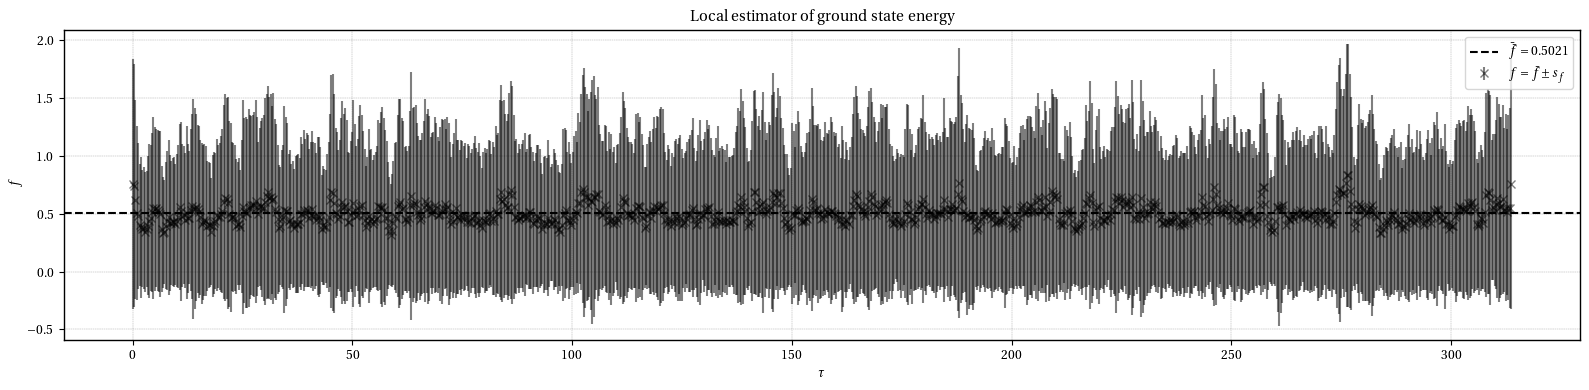

In [18]:
tau_values = np.arange(N) * epsilon
fig, ax = plt.subplots(figsize=(16, 4))
for side in ['top', 'right', 'bottom', 'left']:
        ax.spines[side].set_linewidth(1)
plt.errorbar(tau_values, f_bar, yerr=s_f, color='black', fmt='x', alpha=0.5, label=r"$f=\bar{f}\pm s_f$")
plt.axhline(E0, color='black', linestyle='--', label=rf"$\bar{{\bar{{f}}}} = {E0:.4f}$")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$f$")
plt.title("Local estimator of ground state energy")
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.3, alpha=0.8)
plt.tight_layout()
plt.show()

In [19]:
def calculate_ground_state_histogram(trajectories, delta_x=0.1, x_min=-3, x_max=3, bins=None):
    """
    Calculates the histogram of |\psi_0(x)|^2 from a list of trajectories. 
    It returns
    - bin_centers: central position of the bins.
    - hist_density: normalized values of the histogram (probability density).
    """
    # Building the histogram
    data = trajectories.flatten()

    if bins is None:
        bins = int((x_max - x_min) / delta_x)

    counts, edges = np.histogram(data, bins=bins, range=(x_min, x_max))
    bin_width = edges[1] - edges[0]
    bin_centers = edges[:-1] + bin_width / 2
    hist_density = counts / (counts.sum() * bin_width)
    errors = np.sqrt(counts) / (counts.sum() * bin_width)

    return bin_width, bin_centers, hist_density, errors

In [20]:
def gaussian(x, A, B):
    return A * np.exp(-B * x**2)

# Exponencial adjust
_, bin_centers, hist_density, errors = calculate_ground_state_histogram(trajectories)
popt, pcov = curve_fit(gaussian, bin_centers, hist_density, p0=[1/np.sqrt(np.pi), 1])
A_fit, B_fit = popt
A_err = np.sqrt(pcov[0, 0])
B_err = np.sqrt(pcov[1, 1])
print(f"\nExponential adjust: A = {A_fit:.6f} ± {A_err:.6f}, B = {B_fit:.6f} ± {B_err:.6f}")


Exponential adjust: A = 0.563388 ± 0.000618, B = 0.998288 ± 0.002530


In [21]:
def plot_ground_state_histogram(trajectories, delta_x=0.1, x_min=-3, x_max=3, bins=None, title="Ground state approximated histogram", harmonic=True):
    """
    Plots the histogram of |\psi_0(x)|^2 from a list of trajectories.
    """

    bin_width, bin_centers, hist_density, errors = calculate_ground_state_histogram(trajectories, delta_x, x_min, x_max, bins)

    # Plot
    x_vals = np.linspace(x_min, x_max, 500)
    exact_curve = (1 / np.sqrt(np.pi)) * np.exp(-x_vals**2)

    fig, ax = plt.subplots(figsize=(6, 4))
    for side in ['top', 'right', 'bottom', 'left']:
        ax.spines[side].set_linewidth(1)

    ax.tick_params(axis='both', labelsize=12)

    #plt.bar(bin_centers, hist_density, width=bin_width, align='center', color='black', alpha=0.7, label=r"$|\psi_0(x)|^2$")
    plt.plot(bin_centers, hist_density, 'x', color='black', label='Monte Carlo')
    plt.errorbar(bin_centers, hist_density, yerr=errors, fmt='none', ecolor='black', capsize=2)
    if harmonic: 
        plt.plot(x_vals, exact_curve, 'k--', label=r"$|\psi_0(x)|^2=\frac{1}{\sqrt{\pi}} e^{-x^2}$")
    else:
        x_c = np.abs(f)
        ax.set_xticks([-x_c, 0, x_c])
        ax.set_xticklabels([r"$-x_c$", r"$0$", r"$x_c$"], fontsize=14)
    plt.xlabel(r"$x$", fontsize=16)
    plt.ylabel(r"$|\psi_0(x)|^2$", fontsize=16)
    plt.title(label=title, fontsize=16)
    plt.grid(color='black', linestyle='--', linewidth=0.3, alpha=0.8)
    plt.legend(fontsize=12, frameon=True, edgecolor='black', fancybox=False, framealpha=1.0)
    plt.tight_layout()

    plt.savefig("ground-state-histogram.png")
    plt.show()

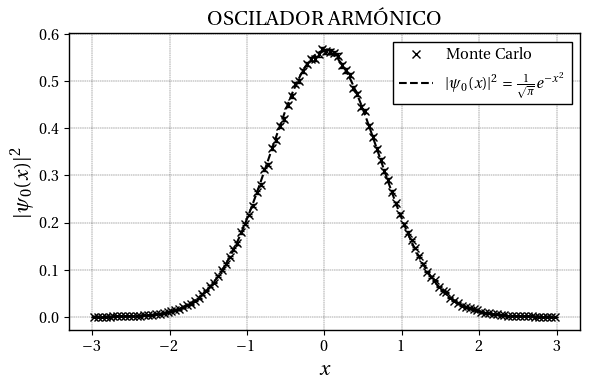

In [23]:
plot_ground_state_histogram(trajectories, delta_x=0.05, title="OSCILADOR ARMÓNICO")

In [36]:
def run_multiple_histograms(n_runs=10, seed=None):
    """
    Run multiple simulations and generate a combined histogram of all trajectories.
    
    Parameters:
    - n_runs: Number of independent runs to combine.
    - seed: Optional random seed for reproducibility.
    """
    if seed is not None:
        np.random.seed(seed)

    all_trajectories = []

    print(f"\nRunning {n_runs} independent simulations...\n")
    for run in range(n_runs):
        print(f" → Simulation {run + 1}/{n_runs}")
        traj = generate_trajectories()
        all_trajectories.append(traj)

    # Concatenate all into one big array of shape (n_runs × N_E, N)
    combined_trajectories = np.vstack(all_trajectories)

    # Optional: analyze energy again (should converge better)
    all_observables = calculate_observables(combined_trajectories)
    _, _, E0_combined, dE0_combined = analyze_observables(all_observables)
    print(f"\nEstimated E0 from all runs: {E0_combined:.6f} ± {dE0_combined:.6f}")

    # Plot histogram using the full set
    plot_ground_state_histogram(combined_trajectories, delta_x=0.05, title=f"OSCILADOR ANARMÓNICO", harmonic=False)

    return combined_trajectories



Running 10 independent simulations...

 → Simulation 1/10
→ Acceptance ratio: 69.826935% (target ~70%)
 → Simulation 2/10
→ Acceptance ratio: 69.978291% (target ~70%)
 → Simulation 3/10
→ Acceptance ratio: 70.016482% (target ~70%)
 → Simulation 4/10
→ Acceptance ratio: 70.111558% (target ~70%)
 → Simulation 5/10
→ Acceptance ratio: 70.242613% (target ~70%)
 → Simulation 6/10
→ Acceptance ratio: 69.913769% (target ~70%)
 → Simulation 7/10
→ Acceptance ratio: 70.172060% (target ~70%)
 → Simulation 8/10
→ Acceptance ratio: 69.973065% (target ~70%)
 → Simulation 9/10
→ Acceptance ratio: 69.964623% (target ~70%)
 → Simulation 10/10
→ Acceptance ratio: 70.153166% (target ~70%)

Estimated E0 from all runs: 3.173332 ± 0.419504


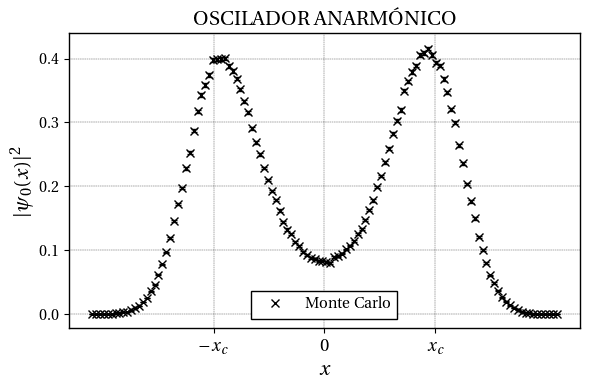

array([[-0.89321933, -1.46318226, -0.08803179, ...,  0.55260388,
         0.15922996, -0.89321933],
       [-1.67440942, -0.79497952, -1.33251081, ...,  0.12840047,
        -0.74413803, -1.67440942],
       [-1.0040673 , -0.78626713, -0.91706477, ...,  0.38477779,
         1.09637937, -1.0040673 ],
       ...,
       [-0.62860054, -1.96610259, -1.61619203, ..., -1.22094098,
        -0.96094116, -0.62860054],
       [-2.08130854, -1.91122565, -2.06594867, ..., -0.77136928,
        -0.92730244, -2.08130854],
       [-2.02533245, -1.39787349, -1.27156548, ..., -1.97547736,
        -1.5674547 , -2.02533245]])

In [38]:
run_multiple_histograms()

#### Trajectory plotter

In [24]:
N = 60

def plot_sample_trajectory(title="A sample trajectory", f=0.0, figsize=['short', 'long']):
    """
    Generates and plots a single quantum trajectory after thermalization (Feynman-style).
    Saves the plot to file.
    """
    x = np.random.normal(0.0, 1.0, N)
    x[N-1] = x[0]  # enforce periodic boundary

    for _ in range(20):
        x, acceptance_ratio  = metropolis_sweep(x)
    
    tau = np.arange(N) * epsilon

    if figsize == 'short':
        fig, ax = plt.subplots(figsize=(3, 5))
    else:
        fig, ax = plt.subplots(figsize=(3, 12))
    ax.plot(x, tau, '-x', markersize=5, color='black', linewidth=1.1)
    
    # Gridlines for discrete time steps
    for t in tau:
        ax.axhline(t, color='black', linestyle='--', linewidth=0.3, alpha=0.8)

    ax.axvline(0.0, color='black', linestyle='-', linewidth=1.0, alpha=0.6, label="$0$")
    if f == 0.0:
        # Show periodic boundary connection line only when f = 0
        ax.set_xticks([x[0]])
        ax.set_xticklabels([r"$x_\mathrm{I}=x_\mathrm{F}$"], fontsize=14)
        ax.axvline(x[0], color='gray', linestyle='--', linewidth=1.2, alpha=0.7)

    # Add classical minima at ±f if f ≠ 0
    else:
        x_c = np.abs(f)
        ax.set_xticks([-x_c, 0, x_c])
        ax.set_xticklabels([r"$-x_c$", r"$0$", r"$x_c$"], fontsize=14)
        ax.axvline(x_c, color='black', linestyle=':', linewidth=1.3, alpha=0.9, label=r"$x_c$")
        ax.axvline(-x_c, color='black', linestyle=':', linewidth=1.3, alpha=0.9, label=r"$-x_c$")


    ax.set_title(label=title, fontsize=16, pad=10)
    for side in ['top', 'right', 'bottom', 'left']:
        ax.spines[side].set_linewidth(1)

    # Annotate discretization info
    ax.text(0.05, 0.95, f"$N = {N}$ \n $\\epsilon = {epsilon:.4f}$",
            transform=ax.transAxes, fontsize=12, verticalalignment='top',
            bbox=dict(facecolor='white', edgecolor='black'))

    # Hide ticks and labels for a cleaner Feynman-style appearance
    ax.set_yticks([])
    ax.set_xlabel("$x(\\tau)$", fontsize=16)
    ax.set_ylabel("$\\tau$", fontsize=16)
    
    x_range = max(abs(np.min(x)), abs(np.max(x)), abs(f)) + 0.5
    ax.set_xlim(-x_range, x_range)

    plt.tight_layout()
    plt.savefig("sample_trajectory.png")
    plt.show()

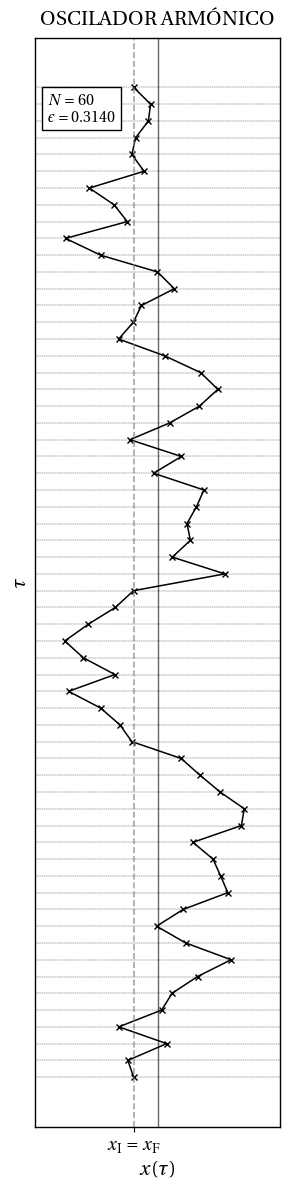

In [26]:
plot_sample_trajectory("OSCILADOR ARMÓNICO", figsize='long')